<a href="https://colab.research.google.com/github/HuwCheston/Crowdsource-Jitter-Analysis/blob/main/Crowdsource_Jitter_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Telecommunication Jitter Analysis***

<img src="https://images.unsplash.com/photo-1606770347238-77fcfd29906c?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1975&q=80, width=100" alt="cover" width=400>

# **1. Create the recording.**
One of the ways we can measure how latency changes over time is to repeatedly send a consistent sound source over a network and measure how long it takes for this to be received. We can do this quite easily with a metronome and two devices connected to the same Zoom call.

## You will need.
*   Two devices capable of connecting to the internet (laptop, phone, tablet...), with the Zoom client installed on both (download here);
*   A recording device (phone, portable recorder...);
*   Two Zoom accounts (free accounts are fine!).




## Start the call.
**We need to set up a single Zoom call that has both of our devices present as participants.**

On your first device (the *sender device*), open up Zoom and click 'Start Meeting', then 'Join with Computer Audio'. Next, click 'Participants' on the menu at the bottom, then 'Invite' on the tab that opens up. Make a note of the Meeting ID and Meeting Passcode in the window that opens up. On your second device (the *receiver device*), open up Zoom and click 'Join'. Enter the Meeting ID from the call you started with the *sender device*, click 'Join', then enter the Meeting Passcode. On the *sender device*, admit the *receiver device* by clicking 'Admit' on the 'Participants' tab. Then, click 'Join with Computer Audio' on the *receiver device*.

## Set up receiver audio for the test.

On your *receiver device*, navigate to the Zoom settings -> 'Audio'. Set 'Supress background noise' to 'Low'. Underneath 'Music and Professional Audio', enable 'Show in-meeting option to enable 'Original Sound'. Finally, under this option, **disable Echo cancellation**. Now, return to the Zoom call on your *receiver device*, and you should see a drop-down box in the top-left corner that says 'Original Sound: Off'. Turn this on.


## Set up sender audio for the test.

On your *sender device*, download our test audio from the link here. Open this file up and verify that you can play it sucessfully. Return to the Zoom call, and enable your microphone (keeping the *receiver device* microphone disabled). Place both *sender* and *receiver* devices next to each other, and play the test audio file. You should be able to hear the original audio file from the *sender*, and an echo on the *receiver*. **Adjust the volume of both devices until the echo is coming through clearly and without feedback.**

## Conduct the test.

Now, open up your recording device and place this inbetween the *sender* and *receiver*. Begin recording on this device, and start the test audio from the beginning on the *sender*. **Let the recording run all the way through: this should take about three minutes.** Try not to make too much noise while the recording is in progress. Once it has finished, export the audio from your recording device and send it to the computer you're accessing this webpage on. 

# **2. Upload data.**

## Upload your audio.

Now, click on 'Runtime' in the menu at the top of this page, and press 'Restart and run all'. Press 'Yes' in the drop down that follows.

The next cell will ask you to upload the recording you made earlier.
Please click the 'Choose files' button, then navigate in the file browser to the location where you saved the recording.

**Uploading may take several minutes depending on your connection and the size of the file.**

In [ ]:
#@title
from google.colab import files
uploaded = files.upload()

## Describe your internet connection.
In order to gather good quality data, I need to know a bit about your internet connection.

Type in your answer into the box and press enter to move to the next question.





Q1. Please enter the city and country where you made the recording.

In [ ]:
#@title
user_location = input('')

Q2. In your own words, please describe your internet connection (e.g. wired with Ethernet cable, wireless with inbuilt adapter...)

In [ ]:
#@title
internet_description = input('')

Q3. On a scale of 1 to 5 (with 1 meaning never and 5 all the time), how often do you experience dropouts and disconnects when making calls over Zoom or another teleconferencing platform?

In [ ]:
#@title
zoom_quality = input('')

Once you've answered these questions, the audio will begin processing in Python in the cells below.

# **3. Audio Processing**

The following cells will perform these actions:
*   Import dependencies and set constant variables;
*   Load your recording into Python;
*   Reduce any surface noise using the NoiseReduce module;
*   Process onset times for metronome clicks in the Librosa module;
*   Calculate the latency time for each successive metronome click;
*   Visualise the presence of jitter as a histogram and line chart.
*   Save the data locally

You shouldn't need to do anything here, so just allow the code to run all the way through.

## Import dependencies.

In [ ]:
#@title
!pip install noisereduce

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#@title
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy import stats
import noisereduce as nr
import IPython
from datetime import datetime, timezone
import json
import soundfile as sf

In [ ]:
#@title
# Samplerate defaults to 44100 khz
samplerate = 44100
# Tolerance threshold for removing spurious values (in seconds)
tolerance = 0.15
# Number of bins for histogram
num_bins = 10
# Noise reduction threshold: increase to remove more noise
nr_threshold = 1.0

## Load in recording.

In [ ]:
#@title
for fn in uploaded.keys():
    y, sr = librosa.load(fn, sr=samplerate)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


## Clean up audio.

In [ ]:
#@title
reduced_noise = nr.reduce_noise(y, sr, prop_decrease=nr_threshold)

## Process onset times.

In [ ]:
#@title
def onset_analysis(y, sr):
    """Analyse a librosa file and return onset times"""
    onset_times = librosa.onset.onset_detect(y=y, sr=sr, units='time')
    return onset_times

In [ ]:
#@title
processed = onset_analysis(reduced_noise, sr)

## Calculate latency.

In [ ]:
#@title
def get_differences(x) -> list:
    """Return the difference between subsequent elements in array (i.e. real/echoed metronome clicks)"""
    # Set the array to the correct shape
    x = x if x.shape[0] % 2 == 0 else np.delete(x, -1)
    # Calculate the difference between successive elements in the array
    diff = np.diff(x)
    return iter_array(diff)

In [ ]:
#@title
def iter_array(diff) -> list:
    """Iterate through a cleaned array and get the smaller of the two differences for every metronome click"""
    # Remove spurious values from the the differenced array
    it = remove_spurious(diff)  
    # Iterate through array
    vals = []
    for x in it:
        # Append the smaller of two consecutive onsets (e.g. real -> echoed IOI, not echoed -> real IOI)
        try:
            vals.append(min((x, next(it))))
        # Break when generator is exhausted
        except StopIteration as e:
            break
    return vals

In [ ]:
#@title
def remove_spurious(x) -> iter:
    """Remove values below the tolerance threshold from an array, which may be incorrect onsets labelled by Librosa"""
    return iter(x[x > tolerance])

In [ ]:
#@title
arr = get_differences(processed)

## Visualise the jitter.

In [ ]:
#@title
def plot_hist(arr, ax,):
    """Plots a histogram of latency distribution for one recording"""
    # Create graph on subplot
    ax.hist(arr, rwidth=0.9, bins=num_bins)
    # Set appearance of subplot
    plt.text(0.35, 0.0, return_ranges(arr), fontsize=14, transform=plt.gcf().transFigure)
    ax.set(xlim=(min(arr) - tolerance, max(arr) + tolerance),)

In [ ]:
#@title
def plot_line(arr, ax):
    """Plots a line chart of latency progression for one recording"""
    # Create graph on subplot
    ax.plot(arr)
    # Set appearance of subplot
    plt.text(0.35, 0, return_ranges(arr), fontsize=14, transform=plt.gcf().transFigure)

In [ ]:
#@title
def return_ranges(arr):
    """Return the IQR and range for an array"""
    # Calculate the specified major and minor percentiles
    func = lambda ma, mi: str(np.round(np.subtract(*np.percentile(arr, [ma, mi])), 2))
    return f'IQR: {func(75, 25)}s, Range: {func(100, 0)}s'

In [ ]:
#@title
def create_graph(func, arr, xlab, ylab, title,):
    """Creates specified graph with subplots corresponding to each recording"""
    fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
    func(arr, ax)
    ax.set_xlabel(xlab,)
    ax.set_ylabel(ylab, x=0.01)
    ax.set_title(title)
    fig.tight_layout()
    return fig

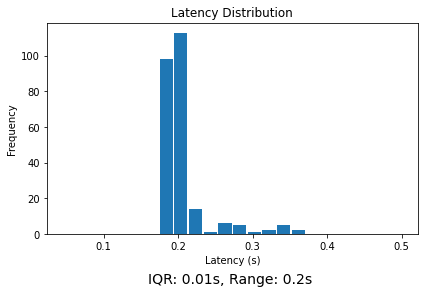

In [ ]:
#@title
hist = create_graph(func=plot_hist, arr=arr, xlab='Latency (s)', ylab='Frequency', title='Latency Distribution')

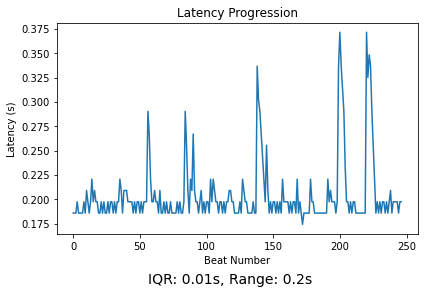

In [ ]:
#@title
line = create_graph(func=plot_line, arr=arr, xlab='Beat Number', ylab='Latency (s)', title='Latency Progression')

## Save data locally

In [ ]:
#@title
now = datetime.now(timezone.utc).strftime("%Y-%m-%d_%H-%M-%S")

In [ ]:
#@title
f = {
    'userinfo': f'{now}_userinfo.json',
    'arr': f'{now}_arr.txt',
    'hist': f'{now}_hist.png',
    'line': f'{now}_line.png',
    'raw_audio': f'{now}_raw.wav',
    'cleaned_audio': f'{now}_cleaned.wav'
}

In [ ]:
#@title
# Save user information as JSON file
user_info = {
    'location': user_location,
    'description': internet_description,
    'teleconference_quality': zoom_quality
}
with open(f['userinfo'], 'w') as fp:
    json.dump(user_info, fp)

In [ ]:
#@title
# Save times array as text file
np.savetxt(f['arr'], arr, delimiter=',')

In [ ]:
#@title
# Save both graphs as PNG files
hist.savefig(f['hist'], facecolor='white', transparent=False, format="png")
line.savefig(f['line'], facecolor='white', transparent=False, format="png")

In [ ]:
#@title
# Save raw and cleaned audio files
sf.write(f['raw_audio'], y, sr, 'PCM_24')
sf.write(f['cleaned_audio'], reduced_noise, sr, 'PCM_24')

# **4. Upload processed data**
In order for you to upload your processed results, you need to allow Colab to access Google Drive. When you run the next cell, a page will open up asking you to grant access: click on your Google account, then click authorise.

NB. Nothing will be changed with your personal Google drive: this process simply allows you to upload files into my drive.

In [ ]:
#@title
from google.colab import auth
auth.authenticate_user()

## Upload the files


In [ ]:
#@title
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build

In [ ]:
#@title
mimetypes = {
    f'{now}_userinfo.json': 'application/json', 
    f'{now}_arr.txt': 'text/plain',
    f'{now}_hist.png': 'image/png',
    f'{now}_line.png': 'image/png',
    f'{now}_raw.wav': 'audio/wav', 
    f'{now}_cleaned.wav': 'audio/wav', 
}
folder_id = '1AM6jbj9y2936H-AgU7zemyZahcsU8m87'

In [ ]:
#@title
def upload_file(folder_id, filename, mimetype):
  """Uploads a local file to shared google drive folder with given mimetype"""
  gd = build('drive', 'v3').files()
  file_metadata = {
      'name': filename,
      'parents': [folder_id]
  }
  media = MediaFileUpload(filename, mimetype=mimetype, resumable=True)
  file = gd.create(body=file_metadata, media_body=media, fields='id').execute()


In [ ]:
#@title
for filename, mimetype in mimetypes.items():
    upload_file(folder_id, filename, mimetype)
